In [1]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy as np

<IPython.core.display.Javascript object>

In [3]:
project_name='forestfires-regression' # will be used by jovian.commit

# Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the download_url function from PyTorch to get the data as a CSV (comma-separated values) file.

In [4]:
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv"
DATA_FILENAME = "forestfires.csv"
download_url(DATASET_URL, '.')

In [5]:
dataframe = pd.read_csv(DATA_FILENAME, sep=",")
print("Shape of the dataframe",dataframe.shape)

Shape of the dataframe (517, 13)


In [6]:
# these two functions help convert categorical attributes to integer type
def month_to_numeric(x):
    if x=='mar':
        return 3
    if x=='feb':
        return 2
    if x=='jan':
        return 1
    if x=='apr':
        return 4
    if x=='may':
        return 5
    if x=='jun':
        return 6
    if x=='jul':
        return 7
    if x=='aug':
        return 8
    if x=='sep':
        return 9
    if x=='oct':
        return 10
    if x=='nov':
        return 11
    if x=='dec':
        return 12
def day_to_numeric(x):
    if x=='tue':
        return 3
    if x=='mon':
        return 2
    if x=='sun':
        return 1
    if x=='wed':
        return 4
    if x=='thu':
        return 5
    if x=='fri':
        return 6
    if x=='sat':
        return 7

In [7]:
#converting two categorical variables to integers
dataframe['month'] = dataframe['month'].apply(month_to_numeric)
dataframe['day'] = dataframe['day'].apply(day_to_numeric)

In [8]:
features_to_normalize = ['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH','wind', 'rain', 'area']

dataframe[features_to_normalize] = dataframe[features_to_normalize].apply(lambda x:(x-x.min()) / (x.max()-x.min()))

# Exloratory Data Analysis 

In [9]:
dataframe.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,0.750,0.428571,3,6,0.870968,0.086492,0.101325,0.090909,0.192926,0.423529,0.700000,0.00000,0.0
1,0.750,0.285714,10,3,0.927742,0.118194,0.775419,0.119430,0.508039,0.211765,0.055556,0.00000,0.0
2,0.750,0.285714,10,7,0.927742,0.146795,0.796294,0.119430,0.398714,0.211765,0.100000,0.00000,0.0
3,0.875,0.571429,3,6,0.941935,0.110958,0.081623,0.160428,0.196141,0.964706,0.400000,0.03125,0.0
4,0.875,0.571429,3,1,0.910968,0.172984,0.110590,0.171123,0.295820,0.988235,0.155556,0.00000,0.0


In [10]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    float64
 1   Y       517 non-null    float64
 2   month   517 non-null    int64  
 3   day     517 non-null    int64  
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    float64
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(11), int64(2)
memory usage: 52.6 KB


In [12]:
dataframe.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,0.458656,0.289222,0.0,0.250000,0.375000,0.750000,1.0
Y,517.0,0.328544,0.175700,0.0,0.285714,0.285714,0.428571,1.0
month,517.0,7.475822,2.275990,1.0,7.000000,8.000000,9.000000,12.0
day,517.0,3.972921,2.143867,1.0,2.000000,4.000000,6.000000,7.0
FFMC,517.0,0.928318,0.071227,0.0,0.922581,0.940645,0.957419,1.0
DMC,517.0,0.378264,0.220698,0.0,0.232598,0.369400,0.486906,1.0
DC,517.0,0.633329,0.290918,0.0,0.504046,0.769673,0.827958,1.0
ISI,517.0,0.160814,0.081274,0.0,0.115865,0.149733,0.192513,1.0
temp,517.0,0.536629,0.186708,0.0,0.427653,0.549839,0.662379,1.0
RH,517.0,0.344567,0.191970,0.0,0.211765,0.317647,0.447059,1.0


X


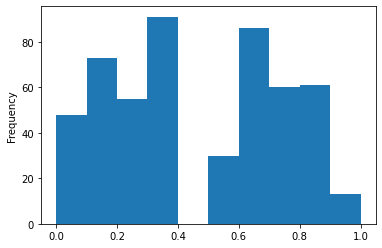

Y


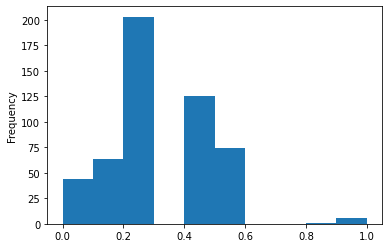

month


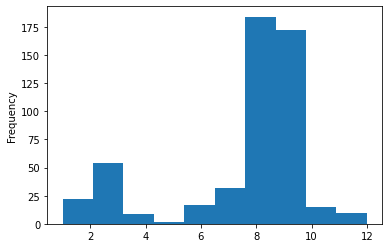

day


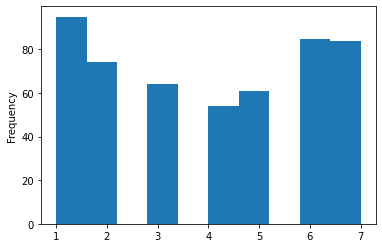

FFMC


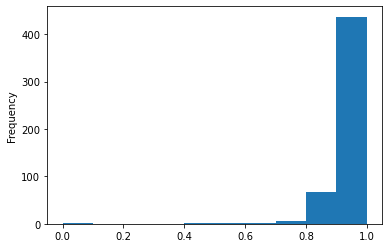

DMC


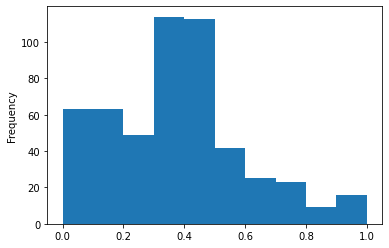

DC


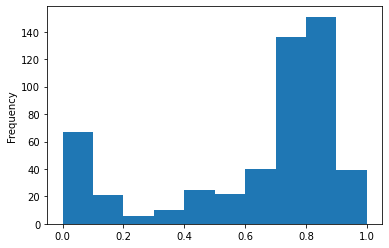

ISI


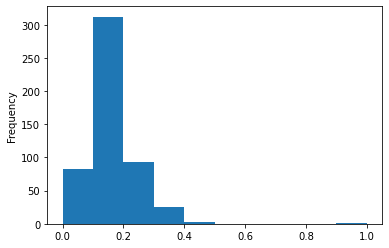

temp


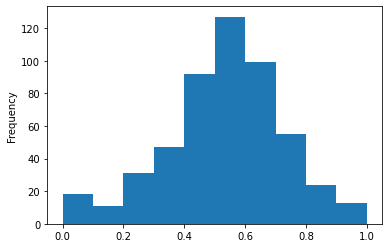

RH


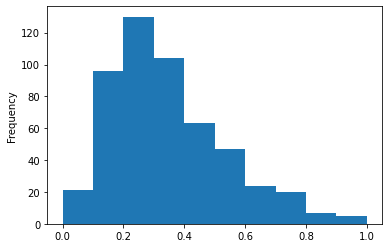

wind


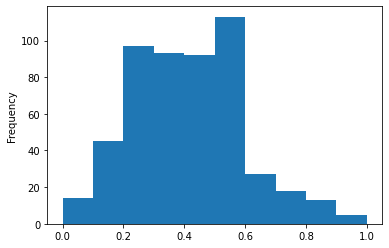

rain


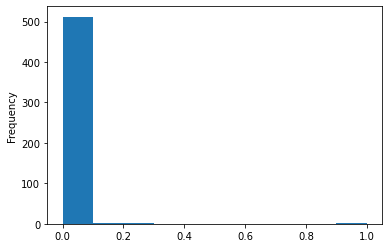

area


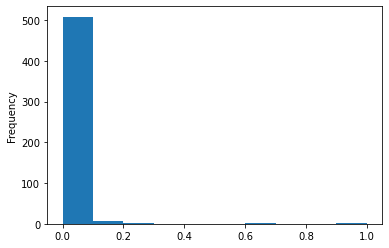

In [15]:
for i in dataframe.columns:
    print(i)
    dataframe[i].plot(kind ='hist')
    plt.show()

Most of the data seems normally distributed

# Data for Training

In [16]:
# Convert from Pandas dataframe to numpy arrays
inputs = dataframe.drop('area', axis=1).values
targets = dataframe['area'].values
# Convert from numpy arrays to torch 
inputs_tensor = torch.from_numpy(inputs).type(torch.float32)
targets_tensor = torch.from_numpy(targets).type(torch.float32)

In [17]:
dataset = TensorDataset(inputs_tensor, targets_tensor)

In [18]:
val_percent = 0.15 # between 0.1 and 0.2
num_rows = dataframe.shape[0]
num_cols = dataframe.shape[1]
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset,[train_size,val_size]) # Use the random_split function to split dataset into 2 parts of the desired length

In [19]:
batch_size = 4
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[ 0.7500,  0.2857, 10.0000,  2.0000,  0.9419,  0.1633,  0.8071,  0.1979,
          0.4695,  0.3529,  0.4556,  0.0000],
        [ 0.8750,  0.5714,  8.0000,  5.0000,  0.9819,  0.7626,  0.8100,  0.2478,
          0.6977,  0.2706,  0.7000,  0.0000],
        [ 0.6250,  0.5714,  8.0000,  7.0000,  0.9974,  0.5613,  0.7448,  0.2496,
          0.9196,  0.1765,  0.5000,  0.0000],
        [ 0.3750,  0.1429,  8.0000,  1.0000,  0.9226,  0.3394,  0.7310,  0.1123,
          0.6206,  0.2235,  0.2000,  0.0000]])
targets: tensor([0.0063, 0.0000, 0.0079, 0.0000])


In [20]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: ········
[jovian] Updating notebook "harishhasti95/forestfires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/harishhasti95/forestfires-regression


'https://jovian.ml/harishhasti95/forestfires-regression'

# MODEL

In [21]:
input_size = 12
output_size = 1
class ForestFires(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                  # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.l1_loss(out, targets)                          # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)                           # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 100 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [22]:
model = ForestFires()

In [23]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0665,  0.0903,  0.0024, -0.2452, -0.2563,  0.0558, -0.1344, -0.1553,
          -0.2157, -0.1080, -0.1519, -0.1455]], requires_grad=True),
 Parameter containing:
 tensor([0.2408], requires_grad=True)]

In [24]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "harishhasti95/forestfires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/harishhasti95/forestfires-regression


'https://jovian.ml/harishhasti95/forestfires-regression'

# TRAINING

In [25]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [26]:
result = evaluate(model, val_loader)
result

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


{'val_loss': 1.1649363040924072}

In [27]:
epochs = 2000
lr = 0.00000049
history1 = fit(epochs, lr, model, train_loader, val_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch [100], val_loss: 0.7581
Epoch [200], val_loss: 0.4913
Epoch [300], val_loss: 0.3921
Epoch [400], val_loss: 0.3369
Epoch [500], val_loss: 0.3125
Epoch [600], val_loss: 0.2953
Epoch [700], val_loss: 0.2814
Epoch [800], val_loss: 0.2663
Epoch [900], val_loss: 0.2506
Epoch [1000], val_loss: 0.2341
Epoch [1100], val_loss: 0.2179
Epoch [1200], val_loss: 0.2019
Epoch [1300], val_loss: 0.1860
Epoch [1400], val_loss: 0.1700
Epoch [1500], val_loss: 0.1543
Epoch [1600], val_loss: 0.1396
Epoch [1700], val_loss: 0.1245
Epoch [1800], val_loss: 0.1101
Epoch [1900], val_loss: 0.0966
Epoch [2000], val_loss: 0.0850


In [28]:
epochs = 2000
lr = 0.000008
history2 = fit(epochs, lr, model, train_loader, val_loader)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch [100], val_loss: 0.0509
Epoch [200], val_loss: 0.0477
Epoch [300], val_loss: 0.0451
Epoch [400], val_loss: 0.0425
Epoch [500], val_loss: 0.0399
Epoch [600], val_loss: 0.0376
Epoch [700], val_loss: 0.0355
Epoch [800], val_loss: 0.0340
Epoch [900], val_loss: 0.0322
Epoch [1000], val_loss: 0.0309
Epoch [1100], val_loss: 0.0299
Epoch [1200], val_loss: 0.0291
Epoch [1300], val_loss: 0.0283
Epoch [1400], val_loss: 0.0275
Epoch [1500], val_loss: 0.0270
Epoch [1600], val_loss: 0.0265
Epoch [1700], val_loss: 0.0259
Epoch [1800], val_loss: 0.0255
Epoch [1900], val_loss: 0.0250
Epoch [2000], val_loss: 0.0246


# PREDICTION

In [29]:
def predict_single(x, model):
    xb = x.unsqueeze(0)
    return model(x).item()

In [33]:
x, target = val_ds[8]
pred = predict_single(x, model)
print("Input: ", x)
print("Target: ", target.item())
print("Prediction:", pred)

Input:  tensor([0.8750, 0.5714, 8.0000, 2.0000, 0.9497, 0.3025, 0.5719, 0.1515, 0.7042,
        0.1412, 0.3000, 0.0000])
Target:  0.0
Prediction: 0.013221919536590576


In [34]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "harishhasti95/forestfires-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Committed successfully! https://jovian.ml/harishhasti95/forestfires-regression


'https://jovian.ml/harishhasti95/forestfires-regression'